In [72]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pickle import dump
from sklearn.utils import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from collections import OrderedDict

combined_data = pd.read_hdf("../source_files/combined_data_C3.hdf5")

INPUT_COLUMNS = ["start_speed", "spin_rate", "spin_dir", "zone", "pitch_type"]
CONTEXT_COLUMNS = ["b_score", "p_score", "b_count", "s_count", "outs", "pitch_num", \
    "on_1b", "on_2b", "on_3b", "inning", "p_throws", "stand", "top"]
OUTPUT_COLUMNS = ["event"]

inputs = combined_data[INPUT_COLUMNS].copy()
context = combined_data[CONTEXT_COLUMNS].copy()

#------------- One-Hot Encode  -----------------
inputs = pd.concat([inputs, pd.get_dummies(inputs.pitch_type)], axis=1)
inputs = inputs.drop(labels="pitch_type", axis=1)

context[["p_throws", "stand"]] = context[["p_throws", "stand"]] == "R"
context[["p_throws", "stand", "top"]] = context[["p_throws", "stand", "top"]].astype(int)
context = context.rename(columns={"p_throws":"p_isrighty", "stand":"b_isrighty", "top":"is_top_inning"})

combined_inputs = pd.concat([inputs, context], axis=1)
# print(combined_inputs.columns)
#Normalization
scaler = StandardScaler().fit(combined_inputs)
combined_inputs = scaler.transform(combined_inputs)
dump(scaler, open('scaler.pkl', 'wb'))

# nn_data = pd.concat([combined_inputs, combined_data[OUTPUT_COLUMNS]], axis=1)
# nn_data.to_hdf("../source_files/model_data.hdf5", key="df")

raw_outputs = pd.get_dummies(combined_data["pitch_event"], dtype="float")
event_names = raw_outputs.columns
# print(raw_outputs)

rename_dict = {
    "*B": "Ball in Dirt",
    "B": "Ball",
    "C": "Called Strike",
    "F": "Foul Ball",
    "H": "Hit by pitch",
    "L": "Foul Bunt",
    "W": "Swinging Strike (Blocked)",
    "M": "Missed Bunt",
    "S": "Swinging Strike",
    "T": "Foul Tip",
}

#print(pd.DataFrame(event_names.values))
event_names = pd.DataFrame(event_names.values).replace(to_replace=rename_dict)
# print(event_names)

combined_inputs = torch.tensor(combined_inputs)
outputs = torch.tensor(raw_outputs.values)



                            0
0                Ball in Dirt
1                        Ball
2              Bunt Groundout
3                Bunt Pop Out
4               Called Strike
5                      Double
6                 Double Play
7                   Foul Ball
8                      Flyout
9                    Forceout
10           Grounded Into DP
11                  Groundout
12               Hit by pitch
13                   Home Run
14                  Foul Bunt
15                    Lineout
16                Missed Bunt
17                    Pop Out
18            Swinging Strike
19                   Sac Bunt
20                    Sac Fly
21                 Sac Fly DP
22                     Single
23                   Foul Tip
24                     Triple
25                Triple Play
26  Swinging Strike (Blocked)


In [49]:
class FFNetPytorch(nn.Module):
  sm = torch.nn.Softmax(dim = 1)
  def __init__(self, input_size, output_size, hl1=100, hl2=25):
    super(FFNetPytorch, self).__init__()
    '''
    Define the layers of the neural network. One hidden layer and output layer.
    The activation function used in between the two layers is sigmoid.
    '''
    self.layer1 = nn.Linear(input_size, hl1, bias = True)
    self.layer2 = nn.Linear(hl1, hl2, bias = True)
    self.layer3 = nn.Linear(hl2, output_size, bias = True)

    self.double()
    

  def forward(self, x):
    '''
    :param x: input to the model (N, NUM_FEATURES)

    :return:
      output: logits of the last layer of the model 
    '''
    x = torch.relu(self.layer1(x))
    x = torch.relu(self.layer2(x))
    x = self.sm(self.layer3(x))

    return x

class CustomDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, i):
    return self.X[i, ...], self.Y[i]
  
  def __len__(self):
    return self.X.shape[0]


In [153]:
class FFNetPytorch(nn.Module):
  sm = torch.nn.Softmax(dim = 1)
  def __init__(self, input_size, output_size, hl1=100, hl2=25):
    super(FFNetPytorch, self).__init__()
    '''
    Define the layers of the neural network. One hidden layer and output layer.
    The activation function used in between the two layers is sigmoid.
    '''
    self.layer1 = nn.Linear(input_size, hl1, bias = True)
    self.layer2 = nn.Linear(hl1, output_size, bias = True)
    # self.layer3 = nn.Linear(hl2, output_size, bias = True)

    self.double()
    

  def forward(self, x):
    '''
    :param x: input to the model (N, NUM_FEATURES)

    :return:
      output: logits of the last layer of the model 
    '''
    x = torch.relu(self.layer1(x))
    # x = torch.relu(self.layer2(x))
    x = self.sm(self.layer2(x))

    return x

class CustomDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, i):
    return self.X[i, ...], self.Y[i]
  
  def __len__(self):
    return self.X.shape[0]


Training

In [166]:
# from pyinstrument import Profiler

# profiler = Profiler()
# profiler.start()

#------------- Train --------------
X_train, X_test, Y_train, Y_test = \
    train_test_split(combined_inputs, outputs, test_size=0.2, random_state=42)

NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = outputs.shape[1]

HIDDEN1_SIZE = 512
HIDDEN2_SIZE = 128

batch_size = 512
max_epochs = 100

print_every = 1
test_every = 1
SAVE_EVERY = 10

LR = 1e-3

SAVE_MODEL = True
LOAD_MODEL = True
SAVE_PATH = "HL1_" + str(HIDDEN1_SIZE) + "_" + str(HIDDEN2_SIZE)
MODEL_SAVE_PATH = "event/models/" + SAVE_PATH + ".pt"
TRAIN_LOSSES_SAVE_PATH = "event/trainingloss/" + SAVE_PATH + ".csv"
TEST_LOSSES_SAVE_PATH = "event/testloss/" + SAVE_PATH + ".csv"
ACCURACY_SAVE_PATH = "event/accuracies/" + SAVE_PATH + ".csv"

CONV_SIZE = 10 #CONVERGENCE_WINDOW_SIZE
CONVERGENCE_THRESHOLD = 0.0003

model = FFNetPytorch(NUM_FEATURES, NUM_CLASSES, hl1=HIDDEN1_SIZE, hl2=HIDDEN2_SIZE)
train_losses =[]
test_losses=[]
train_accuracies = []

if LOAD_MODEL:
    try:
      model = torch.load(MODEL_SAVE_PATH)
      train_losses = np.fromfile(TRAIN_LOSSES_SAVE_PATH, sep=',').tolist()
      test_losses = np.fromfile(TEST_LOSSES_SAVE_PATH, sep=',').tolist()
      train_accuracies = np.fromfile(ACCURACY_SAVE_PATH, sep=',').tolist()
    except FileNotFoundError:
      pass
  
# weight = compute_class_weight(class_weight = "balanced", classes= np.unique(combined_data["pitch_event"]), y = combined_data["pitch_event"])
# print(pd.Series(weight, index=np.unique(combined_data["pitch_event"])))

#print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)#, weight_decay=1e-5)
#loss_fn = nn.CrossEntropyLoss(weight = torch.tensor(weight))
loss_fn = nn.MSELoss()
#torch.manual_seed(314139)
device = "cpu"



dataset_train = CustomDataset(X_train, Y_train)
dataset_test = CustomDataset(X_test, Y_test)

model = model.to(device)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

max_epoch = max_epochs + len(train_losses)
train_dif = 0
epoch = len(train_losses)

print(model)
while epoch < max_epoch \
and (train_dif > CONVERGENCE_THRESHOLD or train_dif == 0):

  batch_losses = []
  batch_accuracies = []
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    prediction = output
    #print(torch.argmax(prediction, dim = 1),torch.argmax(target, dim = 1))
    #print(torch.argmax(target, dim = 1))
    accuracy = torch.sum(torch.argmax(prediction, dim = 1) == torch.argmax(target, dim = 1))/len(target)
    #print(accuracy)
    loss.backward()
    optimizer.step()
    #print(loss.item())
    batch_losses.append(loss.item())
    batch_accuracies.append(accuracy.item())
  
  test_accuracy = torch.mean(torch.Tensor(batch_accuracies)).item()
  train_accuracies.append(test_accuracy)
  train_losses.append(torch.mean(torch.Tensor(batch_losses)).item())
  train_dif = (np.max(train_losses[-CONV_SIZE:])-np.min(train_losses[-CONV_SIZE:]))/np.mean(train_losses[-CONV_SIZE:])
  
  model.eval()
  batch_losses = []

  if epoch % test_every == 0:
    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = loss_fn(output, target)
      batch_losses.append(loss.item())

    test_losses.append(torch.mean(torch.Tensor(batch_losses)).item())

  if SAVE_MODEL & (epoch % SAVE_EVERY == 0) & (epoch != 0):
    print("----- SAVED -----")
    torch.save(model, MODEL_SAVE_PATH)
    np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
    np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
    np.asarray(train_accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')

  if epoch % print_every == 0:
    print('{epoch}/{max_epoch}, Train Loss: {loss:.6f}, Test Loss: {test_loss:.6f}, Accuracy: {accuracy:.4f}%, Difference {diff:.3f}%'.format(
                epoch=epoch, max_epoch=max_epoch, loss=train_losses[-1], test_loss=test_losses[-1], \
                accuracy = test_accuracy*100, diff=train_dif*100))

  epoch += 1

if SAVE_MODEL:
  torch.save(model, MODEL_SAVE_PATH)
  np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
  np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
  np.asarray(train_accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')


FFNetPytorch(
  (layer1): Linear(in_features=27, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=27, bias=True)
)
31/131, Train Loss: 0.025284, Test Loss: 0.025300, Accuracy: 48.8759%, Difference 0.063%
32/131, Train Loss: 0.025282, Test Loss: 0.025286, Accuracy: 48.8678%, Difference 0.060%
33/131, Train Loss: 0.025283, Test Loss: 0.025303, Accuracy: 48.8814%, Difference 0.060%
34/131, Train Loss: 0.025282, Test Loss: 0.025284, Accuracy: 48.8710%, Difference 0.050%
35/131, Train Loss: 0.025280, Test Loss: 0.025300, Accuracy: 48.8711%, Difference 0.052%
36/131, Train Loss: 0.025279, Test Loss: 0.025295, Accuracy: 48.8725%, Difference 0.047%
37/131, Train Loss: 0.025276, Test Loss: 0.025296, Accuracy: 48.8877%, Difference 0.056%
38/131, Train Loss: 0.025276, Test Loss: 0.025287, Accuracy: 48.8775%, Difference 0.044%
39/131, Train Loss: 0.025274, Test Loss: 0.025314, Accuracy: 48.8905%, Difference 0.045%
----- SAVED -----
40/131, Train Loss: 0.025274, Test Lo

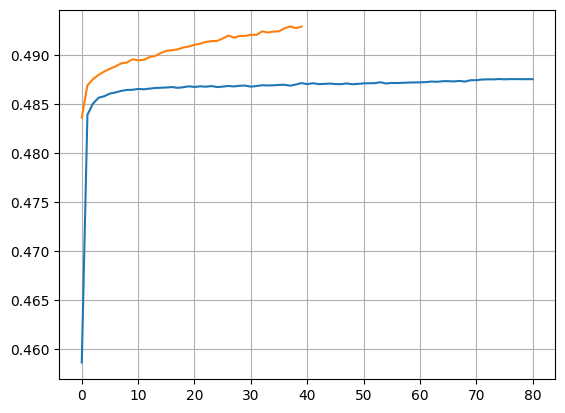

In [54]:
import matplotlib.pyplot as plt


acc_64_64 = np.fromfile("event/accuracies/HL2_16_16.csv", sep=',').tolist()
acc_256_256 = np.fromfile("event/accuracies/HL2_256_256.csv", sep=',').tolist()

plt.figure()
plt.plot(acc_64_64)
plt.plot(acc_256_256)
plt.grid()
#plt.ylim(3.08, 3.3)
plt.show()

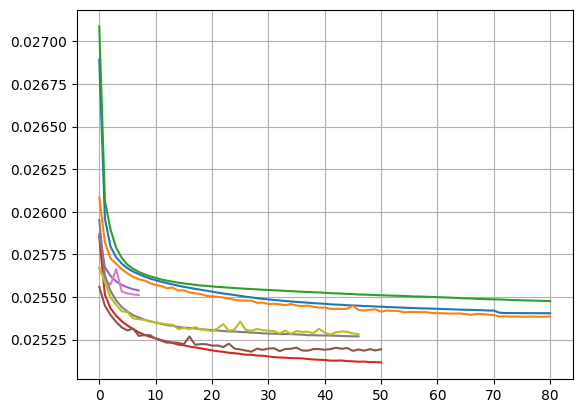

In [167]:
import matplotlib.pyplot as plt


acc_64_64 = np.fromfile("event/trainingloss/HL2_16_16.csv", sep=',').tolist()
test_64_64 = np.fromfile("event/testloss/HL2_16_16.csv", sep=',').tolist()
acc_16_8 = np.fromfile("event/trainingloss/HL2_16_8.csv", sep = ',').tolist()
acc_128_128 = np.fromfile("event/trainingloss/HL2_128_128.csv", sep=',').tolist()
test_128_128 = np.fromfile("event/testloss/HL2_128_128.csv", sep=',').tolist()
acc_256_256 = np.fromfile("event/trainingloss/HL2_256_256.csv", sep=',').tolist()
test_256_256 = np.fromfile("event/testloss/HL2_256_256.csv", sep=',').tolist()
train_hl1_256 = np.fromfile("event/trainingloss/HL1_256_128.csv", sep=',').tolist()
test_hl1_256 = np.fromfile("event/testloss/HL1_256_128.csv", sep=',').tolist()

plt.figure()
plt.plot(acc_64_64)
plt.plot(test_64_64)
plt.plot(acc_16_8)
plt.plot(acc_128_128)
plt.plot(acc_256_256)
plt.plot(test_128_128)
plt.plot(test_256_256)
plt.plot(train_hl1_256)
plt.plot(test_hl1_256)
plt.grid()
#plt.ylim(3.08, 3.3)
plt.show()

In [164]:
context = {
    "b_score": 0,
    "p_score": 0,
    "b_count": 0,
    "s_count": 0,
    "outs": 0,
    "pitch_num": 1,
    "on_1b": 1,
    "on_2b": 1,
    "on_3b": 0,
    "inning": 1,
    "p_isrighty": 0,
    "b_isrighty": 0,
    "is_top_inning": 1
}
indexes = [key for key, val in context.items()]
values = [val for key, val in context.items()]
context = pd.Series(values, index=indexes, dtype=float)


inputs = {
    "start_speed": 90,
    "spin_rate": 1300,
    "spin_dir": 159,
    "zone": 11,
    "pitch_type": "FF"
}

PITCH_TYPES = ['CH', 'CU', 'FC', 'FF', 'FS', 'FT', 'KC', 'KN', 'SI', 'SL']

pitches = [inputs["pitch_type"]==val for val in PITCH_TYPES]
pitches = pd.Series(pitches, index=PITCH_TYPES, dtype=float)

model = "/event/models/HL1_256_128.pt"
model = torch.load(MODEL_SAVE_PATH)
model.eval()
inputs = pd.Series([inputs["start_speed"], inputs["spin_rate"], inputs["spin_dir"], inputs["zone"]], index=["start_speed", "spin_rate", "spin_dir", "zone"], dtype=float)

pitch = pd.concat([inputs, pitches, context])
#print(pitch)

pitch = scaler.transform(np.array(pitch.values).reshape(1, -1))

probabilities = model(torch.tensor(pitch))
probabilities = pd.Series(probabilities.detach().numpy()[0], index=event_names.transpose().to_numpy()[0])

sm = torch.nn.Softmax(dim = 1)
print(probabilities)
# sm = torch.nn.Softmax(dim = 1)
# sm(combined_inputs[0, None])

Ball in Dirt                 1.407743e-09
Ball                         6.894743e-01
Bunt Groundout               2.040644e-08
Bunt Pop Out                 1.759915e-05
Called Strike                1.513139e-01
Double                       1.817671e-03
Double Play                  1.450893e-05
Foul Ball                    4.855625e-02
Flyout                       4.344215e-03
Forceout                     5.150666e-03
Grounded Into DP             5.536169e-03
Groundout                    1.394941e-03
Hit by pitch                 4.961801e-06
Home Run                     1.145722e-03
Foul Bunt                    2.133218e-02
Lineout                      2.589007e-03
Missed Bunt                  1.607718e-04
Pop Out                      3.207383e-03
Swinging Strike              4.186849e-02
Sac Bunt                     1.008105e-02
Sac Fly                      2.718890e-08
Sac Fly DP                   1.111191e-09
Single                       8.891057e-03
Foul Tip                     3.090

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [160]:
print(probabilities.sample(n=20, replace = True, weights = probabilities.values))

Foul Ball          0.172550
Called Strike      0.478793
Called Strike      0.478793
Forceout           0.020026
Swinging Strike    0.051780
Foul Bunt          0.043744
Called Strike      0.478793
Called Strike      0.478793
Foul Ball          0.172550
Called Strike      0.478793
Called Strike      0.478793
Called Strike      0.478793
Called Strike      0.478793
Called Strike      0.478793
Triple             0.004104
Single             0.055474
Lineout            0.023782
Foul Ball          0.172550
Foul Ball          0.172550
Called Strike      0.478793
dtype: float64
